# ERA5 dataset conversion

You may find more information under `data/era5/README.md` for data description

In short, the dataset is made of data on a grid representing the Earth, and each one is an image

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import h5py

import sys; sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
data_dir = Path('/datasets/openai_hackathon/')

# Open hdf5 file
fields = h5py.File(data_dir/'data/2018.h5', 'r')
precipitations = h5py.File(data_dir/'precipitation_data/2018.h5', 'r')

We need to get the variables from here https://github.com/NVlabs/FourCastNet/blob/master/data_process/parallel_copy_small_set.py

In [8]:
variables = ['u10', 'v10', 't2m', 'sp', 'mslp', 't850', 'u1000', 'v1000', 'z1000', 'u850', 'v850', 'z850', 'u500', 'v500', 'z500', 't500', 'z50', 'r500', 'r850', 'tcwv', 'sst']

# variables description dictionary
variables_description = {
    'u10': '10 metre U wind component [m/s]',
    'v10': '10 metre V wind component [m/s]',
    't2m': '2 metre temperature [K]',
    'sp': 'Surface pressure [Pa]',
    'mslp': 'Mean sea level pressure [Pa]',
    't850': 'Temperature at 850 hPa [K]',
    'u1000': '1000 metre U wind component [m/s]',
    'v1000': '1000 metre V wind component [m/s]',
    'z1000': '1000 metre geopotential [m^2/s^2]',
    'u850': '850 metre U wind component [m/s]',
    'v850': '850 metre V wind component [m/s]',
    'z850': '850 metre geopotential [m^2/s^2]',
    'u500': '500 metre U wind component [m/s]',
    'v500': '500 metre V wind component [m/s]',
    'z500': '500 metre geopotential [m^2/s^2]',
    't500': 'Temperature at 500 hPa [K]',
    'z50': '50 metre geopotential [m^2/s^2]',
    'r500': 'Relative humidity at 500 hPa [%]',
    'r850': 'Relative humidity at 850 hPa [%]',
    'tcwv': 'Total column water vapour [kg/m^2]',
    'sst': 'Sea surface temperature [K]'
}

## One week

In [9]:
# 7 days slice
start = 1072 # around Nov 13
end = start +  7*4 # 3 days * 4 time steps per day
data_sliced = fields['fields'][start:end, :, :, :]
precip_sliced = precipitations['tp'][start:end, :, :]

In [10]:
# Save in a single file with variable names
with h5py.File('single_week.h5', 'w') as f:
    for i, var in enumerate(variables):
        f.create_dataset(var, data=data_sliced[:, i, :, :])
        f[var].attrs['description'] = variables_description[var]
    f.create_dataset('tp', data=precip_sliced)
    f['tp'].attrs['description'] = 'Total precipitation [mm]'

In [12]:
## Single

# 7 days slice
start = 1072 # around Nov 13
end = start +  1*1 # 3 days * 4 time steps per day
data_sliced = fields['fields'][start:end, :, :, :]
precip_sliced = precipitations['tp'][start:end, :, :]


# Save in a single file with variable names
with h5py.File('sample.h5', 'w') as f:
    for i, var in enumerate(variables):
        f.create_dataset(var, data=data_sliced[:, i, :, :])
        f[var].attrs['description'] = variables_description[var]
    f.create_dataset('tp', data=precip_sliced)
    f['tp'].attrs['description'] = 'Total precipitation [mm]'

## Video



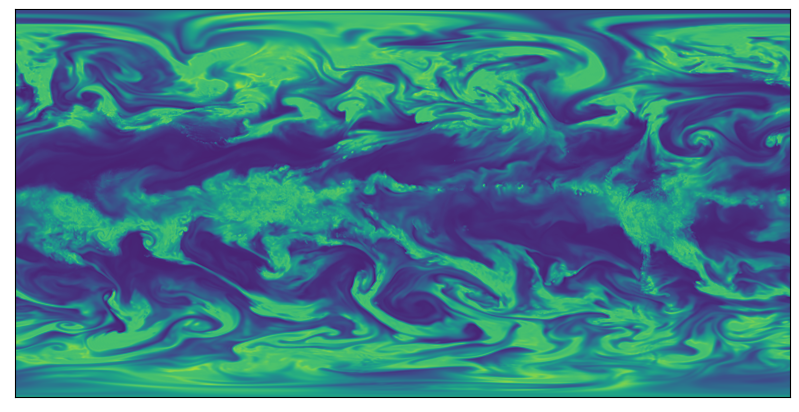

In [41]:
from matplotlib.gridspec import GridSpec

time = -1
interpolation = 'spline16'
cmap = 'viridis'
var_idx = -4

# get max and min
max_val = np.max(fields['fields'][:50, var_idx])
min_val = np.min(fields['fields'][:50, var_idx])
norm = plt.Normalize(min_val, max_val)

def plot_func(i):
    fig, ax =  plt.subplots(1,1,figsize=(10, 10))
    ax.imshow(fields['fields'][i, var_idx], interpolation=interpolation, cmap=cmap, norm=norm)
    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])
    return fig

_ = plot_func(60)

In [42]:
from tqdm.auto import tqdm
import os
import subprocess
import glob
import multiprocessing as mp
    
folder='/tmp/'

def _plot(i):
    fig = plot_func(i)
    fig.savefig(os.path.join(folder, 'frame_{:04d}.png'.format(i)))
    plt.close(fig)

def generate_video(num,  output_dir=os.getcwd()):
    """Image: numpy array of shape (T, H, W)"""
    print("Saving images to {}".format(folder))

    with mp.Pool(8) as p:
        list(tqdm(p.imap(_plot, range(num)), total=num))

    
    print("Removing previous video")
    subprocess.call("rm -f {}/video.mp4".format(output_dir), shell=True)
    
    print("Generating video")
    os.chdir(folder)
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'frame_%04d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        '-vf',  "pad=ceil(iw/2)*2:ceil(ih/2)*2", 
        str(Path(output_dir) / 'video.mp4')
    ])
    print("Done. Removing images")
    for file_name in glob.glob(str(Path(folder) / "*.png")):
        os.remove(file_name)


generate_video(50, output_dir='/datasets/botu/Dev/Green-Planet-Transformers-3/')

Saving images to /tmp/


100%|██████████| 50/50 [00:01<00:00, 37.16it/s]


Removing previous video
Generating video


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Done. Removing images


frame=  187 fps=0.0 q=-1.0 Lsize=    1193kB time=00:00:06.13 bitrate=1593.5kbits/s dup=137 drop=0 speed=6.44x    
video:1190kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.257194%
[libx264 @ 0x55775a86d180] frame I:2     Avg QP:17.61  size: 41390
[libx264 @ 0x55775a86d180] frame P:47    Avg QP:19.84  size: 22178
[libx264 @ 0x55775a86d180] frame B:138   Avg QP:20.61  size:   672
[libx264 @ 0x55775a86d180] consecutive B-frames:  1.1%  1.1%  1.6% 96.3%
[libx264 @ 0x55775a86d180] mb I  I16..4: 32.8% 57.7%  9.5%
[libx264 @ 0x55775a86d180] mb P  I16..4:  1.6%  3.5%  1.1%  P16..4:  5.9% 11.0%  7.8%  0.0%  0.0%    skip:69.1%
[libx264 @ 0x55775a86d180] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  4.3%  0.3%  0.1%  direct: 0.1%  skip:95.1%  L0:49.4% L1:45.6% BI: 5.0%
[libx264 @ 0x55775a86d180] 8x8 transform intra:56.2% inter:72.2%
[libx264 @ 0x55775a86d180] coded y,uvDC,uvAC intra: 52.9% 65.9% 62.3% inter: 4.8% 5.9% 4.6%
[libx264 @ 0x55775a86d180] i16 v,h,dc,p: 46%